# Learning to Download Data

First, let's learn how to download transcript data and collect just the pieces we need. We will start with the first episode of campaign 1 of Critical Role, [Arrival at Kraghammer](https://criticalrole.fandom.com/wiki/Arrival_at_Kraghammer/Transcript).

In [2]:
from bs4 import BeautifulSoup

import urllib
import urllib.request

In [3]:
transcript_url = 'https://criticalrole.fandom.com/wiki/Arrival_at_Kraghammer/Transcript'

with urllib.request.urlopen(transcript_url) as response:
  html = response.read()

transcript = BeautifulSoup(html, 'html.parser')

In [4]:
print(transcript.prettify()[1:200])

!DOCTYPE html>
<html class="client-nojs sse-other" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   Arrival at Kraghammer/Transcript | Critical Role Wiki | Fandom
  </title>
  <scr


We are using the BeautfulSoup object in order to parse the html from our target page. The main body of the page is in the `mw-parser-output` div, so let's get that:

In [5]:
main_div = transcript.find_all('div', {'class': 'mw-parser-output'})[0]

Then, we can iterate through the children of the div. We expect that each major section will start with a `h2` element, followed by a number of `p` elements, each of which will be a line/section of dialogue from someone. We will collect the paragraphs into a list for each major section:

In [6]:
current_section = None
sections = {}
for child in main_div.children:
    if child.name == "h2":
        current_section = child.text[:-2]
        sections[current_section] = []
    elif child.name == "p" and current_section is not None:
        sections[current_section].append(child.text)
        
print(sections)

{'Pre-Show': ["MATT: Hello everyone. My name is Matthew Mercer, voice actor and Dungeon Master for Critical Role on Geek & Sundry, where I take a bunch of other voice actors and run them through a fantastical fantasy adventure through the world of Dungeons & Dragons. We play every Thursday at 7:00pm Pacific Standard Time on Geek & Sundry's Twitch stream. Please come watch us live if you have the opportunity. Back episodes and future episodes will be uploaded on the Geek & Sundry website. You can also check them out there. In the meantime, enjoy!\nWelcome to first episode of Critical Role, and what this basically is is a continuation of our weekly D&D game. Me and a bunch of other likely nerdy and enjoyable voice actors gathering around, rolling some dice, killing some creatures, having some adventure. Now we have the pleasure of bringing it on the stream for you to watch, enjoy, and occasionally interact with. Before we get to that, to give you a little backstory on the characters you'

We can see that there are many lines of dialogue that we need to go through and clean up. Let's look at the beginning of each line to see that they are formatted a certain way. They start with a NAME: and then the dialogue, with occasional other formats (for sound effects, for example).

In [7]:
for section in sections:
    print(f'---- {section} ----')
    for p in sections[section][:10]:
        print(p[:10])

---- Pre-Show ----
MATT: Hell
TRAVIS: Ri
[record sc
TRAVIS (CO
MARISHA: A
[thunder c
MARISHA (C
TALIESIN: 
SAM: Oh, y
ORION: Gre
---- Part I ----
MATT: All 
TRAVIS: So
MATT: Yep,
TRAVIS: Ne
MATT: Yeah
LAURA: Oh 
SAM: In th
MATT: In t
SAM: Wow! 
TRAVIS: We
---- Break ----
TRAVIS: Ri
[record sc
TRAVIS (CO
MARISHA: A
[thunder c
MARISHA (C
TALIESIN: 
SAM: Oh, y
ORION: Gre
LIAM: Neve
---- Part II ----
MATT: Hell
SAM: Oh, J
TRAVIS: We
SAM: Are w
TALIESIN: 
LAURA and 
SAM: Eggs 
TALIESIN: 
LIAM: I wa
MARISHA: D


For now, let's label the unusual formats as 'NOSPEAKER' and separate out the names and dialogue. We may want the names as labels later.

In [8]:
parsed_sections = {key: [[x.strip() for x in y.split(':', 1)] if ':' in y else ['NOSPEAKER', y] for y in value]
                   for (key, value) in sections.items()}
print(parsed_sections.get('Pre-Show')[:5])

[['MATT', "Hello everyone. My name is Matthew Mercer, voice actor and Dungeon Master for Critical Role on Geek & Sundry, where I take a bunch of other voice actors and run them through a fantastical fantasy adventure through the world of Dungeons & Dragons. We play every Thursday at 7:00pm Pacific Standard Time on Geek & Sundry's Twitch stream. Please come watch us live if you have the opportunity. Back episodes and future episodes will be uploaded on the Geek & Sundry website. You can also check them out there. In the meantime, enjoy!\nWelcome to first episode of Critical Role, and what this basically is is a continuation of our weekly D&D game. Me and a bunch of other likely nerdy and enjoyable voice actors gathering around, rolling some dice, killing some creatures, having some adventure. Now we have the pleasure of bringing it on the stream for you to watch, enjoy, and occasionally interact with. Before we get to that, to give you a little backstory on the characters you'll be seei

Now let's see how many lines each speaker has. It might also tell us if there is additional cleanup that needs to be done.

In [9]:
speakers = {key: [x[0] for x in value] for (key, value) in parsed_sections.items()}
print(speakers.get('Pre-Show')[:5])

['MATT', 'TRAVIS', 'NOSPEAKER', "TRAVIS (CONT'D)", 'MARISHA']


In [10]:
from collections import Counter
for section, names in speakers.items():
    print(f'---- {section} ----')
    print(Counter(names))

---- Pre-Show ----
Counter({'MATT': 15, 'MARISHA': 7, 'ORION': 6, 'NOSPEAKER': 5, 'TRAVIS': 4, 'LAURA': 4, 'SAM': 3, 'ZAC': 3, 'TALIESIN': 2, 'LIAM': 2, "TRAVIS (CONT'D)": 1, "MARISHA (Cont'd)": 1, 'ORION and MATT': 1, "ORION (Cont'd)": 1})
---- Part I ----
Counter({'MATT': 329, 'LAURA': 193, 'SAM': 123, 'LIAM': 102, 'TRAVIS': 96, 'MARISHA': 84, 'ORION': 69, 'TALIESIN': 31, 'NOSPEAKER': 9, 'ALL': 4, 'LAURA and LIAM': 2, 'ZAC': 2, 'LAURA and SAM': 1, 'MATT and MARISHA': 1, 'LAURA and TRAVIS': 1, 'TALIESIN and MARISHA': 1, 'ORION and MARISHA': 1})
---- Break ----
Counter({'NOSPEAKER': 2, 'TRAVIS': 1, "TRAVIS (CONT'D)": 1, 'MARISHA': 1, "MARISHA (Cont'd)": 1, 'TALIESIN': 1, 'SAM': 1, 'ORION': 1, 'LIAM': 1, 'LAURA': 1})
---- Part II ----
Counter({'MATT': 367, 'LAURA': 150, 'SAM': 115, 'MARISHA': 94, 'ORION': 93, 'TRAVIS': 89, 'TALIESIN': 85, 'LIAM': 56, 'NOSPEAKER': 19, 'ALL': 4, 'ZAC': 3, 'LAURA and TRAVIS': 1, 'SAM and TALIESIN': 1, 'TRAVIS and LAURA': 1, 'LAURA and SAM': 1, 'SAM and MAT

We can also use `pandas` to organize our data and make it easier to visualize.

In [11]:
import pandas as pd
pre_show_transcript = pd.DataFrame(parsed_sections.get('Pre-Show'), columns = ['speaker', 'line'])
part_i_transcript = pd.DataFrame(parsed_sections.get('Part I'), columns = ['speaker', 'line'])
break_transcript = pd.DataFrame(parsed_sections.get('Break'), columns = ['speaker', 'line'])
part_ii_transcript = pd.DataFrame(parsed_sections.get('Part II'), columns = ['speaker', 'line'])
pre_show_transcript.head()

,speaker,line
0,MATT,"Hello everyone. My name is Matthew Mercer, voi..."
1,TRAVIS,"Right, listen up! If you have ale, then you ha..."
2,NOSPEAKER,[record scratch] Wait.\n
3,TRAVIS (CONT'D),"Easily the brains of the group, Grog is often ..."
4,MARISHA,A first impression of Keyleth would leave you ...


In [12]:
print(pre_show_transcript['speaker'].value_counts())
print(part_i_transcript['speaker'].value_counts())
print(break_transcript['speaker'].value_counts())
print(part_ii_transcript['speaker'].value_counts())

speaker
MATT                15
MARISHA              7
ORION                6
NOSPEAKER            5
TRAVIS               4
LAURA                4
SAM                  3
ZAC                  3
TALIESIN             2
LIAM                 2
TRAVIS (CONT'D)      1
MARISHA (Cont'd)     1
ORION and MATT       1
ORION (Cont'd)       1
Name: count, dtype: int64
speaker
MATT                    329
LAURA                   193
SAM                     123
LIAM                    102
TRAVIS                   96
MARISHA                  84
ORION                    69
TALIESIN                 31
NOSPEAKER                 9
ALL                       4
LAURA and LIAM            2
ZAC                       2
LAURA and SAM             1
MATT and MARISHA          1
LAURA and TRAVIS          1
TALIESIN and MARISHA      1
ORION and MARISHA         1
Name: count, dtype: int64
speaker
NOSPEAKER           2
TRAVIS              1
TRAVIS (CONT'D)     1
MARISHA             1
MARISHA (Cont'd)    1
TALIESIN        

In [13]:
pre_show_transcript.insert(0, 'section', 'Pre-Show')
part_i_transcript.insert(0, 'section', 'Part I')
part_ii_transcript.insert(0, 'section', 'Part II')
main_transcript = pd.concat([part_i_transcript, part_ii_transcript])

In [14]:
print(main_transcript['speaker'].value_counts())

speaker
MATT                    696
LAURA                   343
SAM                     238
TRAVIS                  185
MARISHA                 178
ORION                   162
LIAM                    158
TALIESIN                116
NOSPEAKER                28
ALL                       8
ZAC                       5
LAURA and LIAM            2
LAURA and SAM             2
LAURA and TRAVIS          2
TALIESIN and MARISHA      1
ORION and MARISHA         1
MATT and MARISHA          1
SAM and TALIESIN          1
TRAVIS and LAURA          1
SAM and MATT              1
Name: count, dtype: int64


<Axes: ylabel='speaker'>

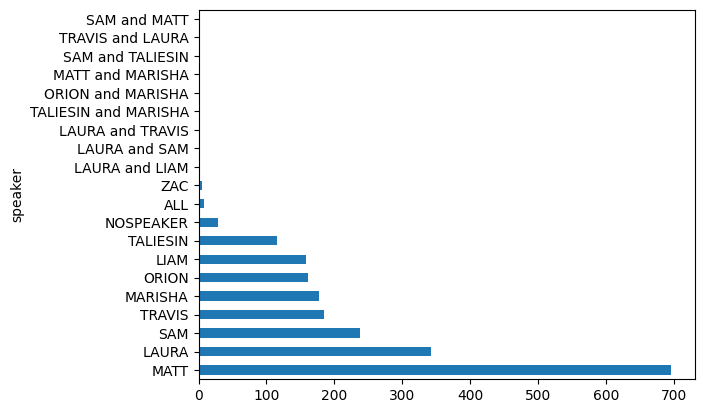

In [15]:
main_transcript['speaker'].value_counts().plot(kind = 'barh')

Let's look at some summaries using matplotlib, including number of lines for each speaker and average length.

In [63]:
main_transcript['linelength'] = [len(x) for x in main_transcript['line']]
main_summary = main_transcript.groupby(['section', 'speaker'], as_index = False).agg({'line': 'count', 'linelength': 'mean'})
main_summary

,section,speaker,line,linelength
0,Part I,ALL,4,6.000000
1,Part I,LAURA,193,34.336788
2,Part I,LAURA and LIAM,2,5.500000
3,Part I,LAURA and SAM,1,8.000000
4,Part I,LAURA and TRAVIS,1,6.000000
5,Part I,LIAM,102,52.715686
6,Part I,MARISHA,84,31.928571
7,Part I,MATT,329,125.899696
8,Part I,MATT and MARISHA,1,15.000000
9,Part I,NOSPEAKER,9,31.333333


In [83]:
main_summary_lines = main_summary.pivot(index = 'speaker', columns = 'section', values = 'line').fillna(0)
main_summary_lines = main_summary_lines.sort_index(key = main_summary_lines.sum(1).get, ascending = False)

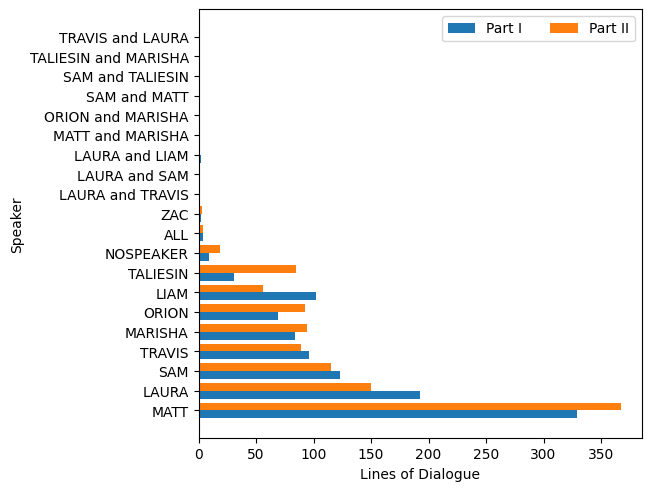

In [84]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(main_summary_lines))  # the label locations
width      = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
for sec in ['Part I', 'Part II']:
    ax.barh(x + width * multiplier, main_summary_lines[sec], width, label = sec)
    multiplier = 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Lines of Dialogue')
ax.set_ylabel('Speaker')
ax.set_yticks(x + width / 2, main_summary_lines.index)
ax.legend(loc='upper right', ncols=3)
#ax.set_ylim(0, 250)

plt.show()

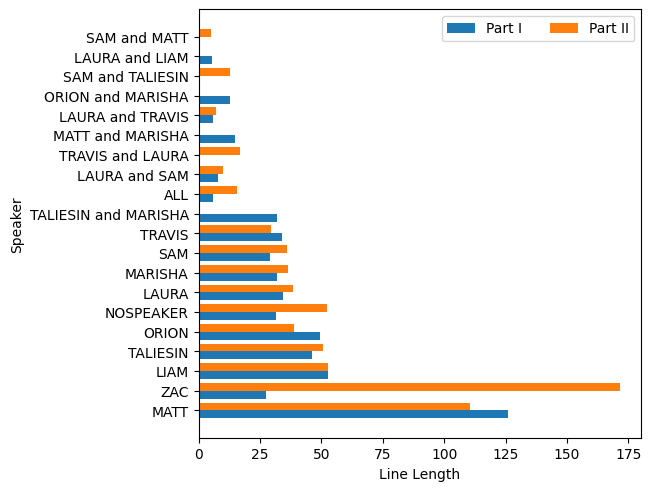

In [85]:
main_summary_linelength = main_summary.pivot(index = 'speaker', columns = 'section', values = 'linelength').fillna(0)
main_summary_linelength = main_summary_linelength.sort_index(key = main_summary_linelength.sum(1).get, ascending = False)

x          = np.arange(len(main_summary_linelength))  # the label locations
width      = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
for sec in ['Part I', 'Part II']:
    ax.barh(x + width * multiplier, main_summary_linelength[sec], width, label = sec)
    multiplier = 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Line Length')
ax.set_ylabel('Speaker')
ax.set_yticks(x + width / 2, main_summary_linelength.index)
ax.legend(loc='upper right', ncols=3)
#ax.set_ylim(0, 250)

plt.show()

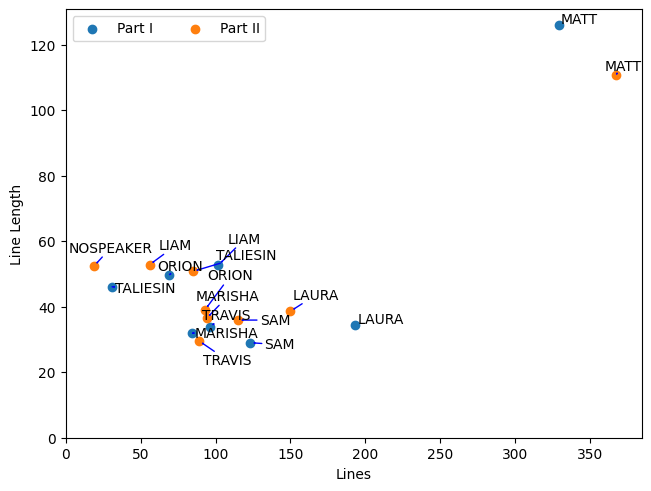

In [128]:
from adjustText import adjust_text

fig, ax = plt.subplots(layout = 'constrained')

many_lines_data = main_summary[main_summary['line'] > 10].reset_index()

for sec in ['Part I', 'Part II']:
    part_data = many_lines_data[many_lines_data['section'] == sec]
    ax.scatter(part_data['line'], part_data['linelength'], label = sec)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Lines')
ax.set_ylabel('Line Length')
ax.legend(loc = 'upper left', ncols = 3)
ax.set_xlim(left = 0)
ax.set_ylim(bottom = 0)

ax = [ax.annotate(txt, (many_lines_data['line'][i], many_lines_data['linelength'][i]))
      for i, txt in enumerate(many_lines_data['speaker'])]
adjust_text(ax, arrowprops = dict(arrowstyle = '->', color = 'b'), min_arrow_len = 5)


plt.show()